- Identify a societal problem
- Justify and Contextualize the problem
- Develop research questions that advance this problem
- Motivate the specific research question by constructing arguments and providing evidence
- Find and describe the provenance of an appropriate dataset(s) to answer the question
- Manipulate and transform the data using Python
- Create visualizations and perform statistical analyses in order to generate results
- Interpret your results to answer your question
- Critically evaluate your analysis in a societal context from an ethical perspective

# Student Disparity Analysis
By Zihan (Anna) Wu

## Introduction

The following analysis examines data from the Delaware Department of Education (student attendance and dropout rate) across different races. It aims to find out if there are any existing racial disparities in education in Delaware and what factors may contribute to any differences found. 

#### Problem

There has long been a history of racial inequalities in education. //justification

#### Motivating Questions

- What are the differences in student attendance and dropout across different races in Delaware?
- Is there currently still a disparity in student performance between white students and students of color in Delaware? 
- If there is a disparity, how might it have changed over time?

#### Datasets

This analysis utilizes three Delaware Department of Education datasets containing information on K-12 students for all schools in Delaware.

- Student Attendance 
    - https://data.delaware.gov/Education/Student-Attendance/crb4-kdc7
    - Contains data on students' average days of enrollment, students' average days absent, and percentages of students deemed chronically absent. 
- Student Dropout 
    - https://data.delaware.gov/Education/Student-Dropout/7u9f-65y3
    - Contains data on the number of student dropping out, as well as dropout rates across different subgroups. 

#### Considerations Moving Forward

The hope in analyzing this data is to help identify a problem and difference in education so that people can be more aware in addressing the issue. My concern is that some may use the info presented to further perpetuate racial stereotypes, or attribute the differences in performance to something inherent to the students, rather than external forces.

Please continue to be mindful that differences in student performance in school may not solely be the due to educational inequality, but could be a result of general inequality and effects of stereotypes outside of school. Though the data may show a problem in education, to effectively address the issue one may have to work on a broader scale and look at factors outside education. 

In [18]:
# Set up
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats as scipystats
import statsmodels.api
from statsmodels import stats as smstats
import random

# Import data
att = pd.read_csv('data/Student_Attendance.csv')
growth = pd.read_csv('data/Student_Growth.csv')
dropout = pd.read_csv('data/Student_Dropout.csv')

# Renaming to be concise
att = att.replace('Native Hawaiian/Pacific Islander', 'Hawaiian/Pacific Islander' )
growth = growth.replace('Native Hawaiian/Pacific Islander', 'Hawaiian/Pacific Islander' )
dropout = dropout.replace('Native Hawaiian/Pacific Islander', 'Hawaiian/Pacific Islander' )

## Student Attendance Analysis

First we will look at the student attendance dataset and some of the trends in attendance rates across races.

#### Data Overview

In [11]:
#Organizing data

# Only looking at the entire state level
att_state = att[ (att["District Code"] == 0)]

# Remove redacted categories like foster care
# Does not give data for those specific categories alone, but data is included in larger overall categories
att_state =  att_state[att_state['Rowstatus'] != 'REDACTED']

# Only separating by race for now
att_state_all = att_state[(att_state['Grade'] == 'All Students') &
                      (att_state['Gender'] == 'All Students') &
                      (att_state['SpecialDemo'] == 'All Students') ]

att_state_all = att_state_all[ att_state_all['SubGroup'] != 'All Students' ]

unique = att_state_all["Race"].unique().tolist()
print("Here are the racial categories we will be looking at: \n" , unique)

# Data ranges from 2015-2019
print("\nHere is a preview of the data: ")
att_state_all.head()


Here are the racial categories we will be looking at: 
 ['Hispanic/Latino', 'Native American', 'African American', 'White', 'Asian American', 'Hawaiian/Pacific Islander', 'Multi-Racial']

Here is a preview of the data: 


,School Year,District Code,District,School Code,Organization,Race,Gender,Grade,SpecialDemo,Geography,SubGroup,Rowstatus,StudentsChronicallyAbsent,Students,PctStudentsChronicallyAbsent,AvgDaysEnrolled,AvgDaysAbsent
12,2015,0,State of Delaware,0,State of Delaware,Hispanic/Latino,All Students,All Students,All Students,All Students,Hispanic/Latino,REPORTED,3414.0,21920.0,15.57,155.496565,8.703340
327,2015,0,State of Delaware,0,State of Delaware,Native American,All Students,All Students,All Students,All Students,Native American,REPORTED,107.0,577.0,18.54,157.167230,9.878378
566,2015,0,State of Delaware,0,State of Delaware,African American,All Students,All Students,All Students,All Students,African American,REPORTED,8462.0,44747.0,18.91,153.381503,9.189935
895,2015,0,State of Delaware,0,State of Delaware,White,All Students,All Students,All Students,All Students,White,REPORTED,8927.0,65198.0,13.69,161.483502,8.661167
1224,2015,0,State of Delaware,0,State of Delaware,Asian American,All Students,All Students,All Students,All Students,Asian,REPORTED,388.0,5217.0,7.44,158.321772,6.045994


In [12]:
#Setting up graphs

# Graph size
sns.set(rc={'figure.figsize':(9,6)})
sns.set_style("ticks")

# Category order
plotOrder = ['Asian', 'White', 'Hawaiian/Pacific Islander', 'Hispanic/Latino','Multi-Racial', 'Native American','African American']
plotOrderReversed = plotOrder[::-1]

#### Average Days Absent

Let's first take a look at the the average number of days students are absent across the years.

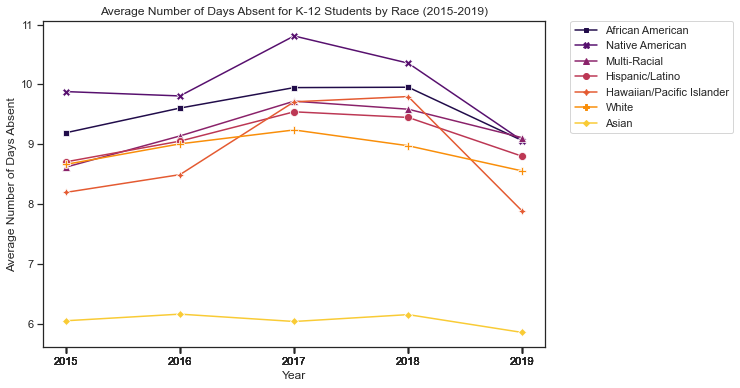

In [13]:
att_plot = sns.lineplot(x = 'School Year',
                        y = 'AvgDaysAbsent',
                        data = att_state_all,
                        hue = 'SubGroup',
                        style = 'SubGroup',
                        markers = True,
                        dashes = False,
                        markersize = 8,
                        hue_order = plotOrderReversed,
                        palette = 'inferno'
                      )

att_plot.set_xticks(att_state_all['School Year'].values)
att_plot.set(xlabel='Year', ylabel="Average Number of Days Absent", title="Average Number of Days Absent for K-12 Students by Race (2015-2019)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

From this data, we start to see that there are some relatively clear differences, such as the average number of days absent for Asian Americans appearing much lower than the rest. The other averages are much closer together, differing by 1 or 2 days, but we start to see a trend of the order of averages holding consistent over the years. 

#### Chronic Absence

The Delaware Department of Education defines "chronically absent" as missing at least 10% of enrolled school days during a year. Taking a look at the percentage of chronically absent students for each category across years, the disparities start to become more apparent. 

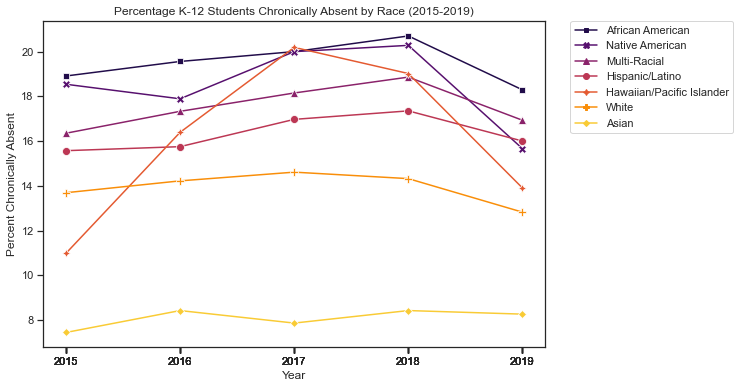

In [37]:
# Creating a line graph
att_plot = sns.lineplot(x = 'School Year',
                        y = 'PctStudentsChronicallyAbsent',
                        data = att_state_all,
                        hue = 'SubGroup',
                        style = 'SubGroup',
                        markers = True,
                        dashes = False,
                        markersize = 8,
                        hue_order = plotOrderReversed,
                        palette = 'inferno'
                      )


att_plot.set_xticks(att_state_all['School Year'].values)
att_plot.set(xlabel='Year', ylabel="Percent Chronically Absent", title="Percentage K-12 Students Chronically Absent by Race (2015-2019)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


#### Observations

While the average number of days absent for the students were fairly close together, the percentage of chronically absent students are more clearly separated. Across the years, few lines cross each other, and the order of the categories is retained, sans the Hawaiian/Pacific Islander group. 
* Across 2015 - 2018, African American and Native American students consistently have the highest rates of chronic absence, as well as the highest average number of days absent
* White and Asian students consistently have lower rates of chronic absence and lower average number of days absent 

Please note that 2019 is not consistent with the past 4 years (both average days absent and percentage of chronic absences take a dive for all students). This change could be due to a difference in data collection, mistakes in data collection, or even changes due to efforts within education. More information will need to be collected and/or examined before coming to conclusions about 2019, so we will be using 2018 as the most recent data moving forward. 

Examining the data for 2018, we see that these differences are statistically significant and are not likely due to chance. Using a 2-proportion test, we can quantify the magnitude of difference a bit. 

In [39]:
state_2018 = att_state_all[ att_state_all["School Year"] == 2018]

def getCell(sg, column):
    return state_2018[state_2018["SubGroup"] == sg ][column].values[0]

def printResult(r1, r2):
    absent_r1 = getCell(r1, "StudentsChronicallyAbsent")
    total_r1 = getCell(r1, "Students")
    absent_r2 = getCell(r2, "StudentsChronicallyAbsent")
    total_r2 = getCell(r2, "Students")
    result = smstats.proportion.test_proportions_2indep(absent_r1, total_r1, absent_r2, total_r2)
    print("\n"+r1 + " - " + r2)
    print("Statistic: " + str(result.statistic))
    print("P-value: " + str(result.pvalue))
    
print("Results of the two proportion tests:")

printResult("White", "African American")
printResult("White", "Native American")
printResult("White", "Multi-Racial")
printResult("White", "Hispanic/Latino")
printResult("White", "Asian")

Results of the two proportion tests:

White - African American
Statistic: -27.005030381660873
P-value: 1.2899466335633519e-160

White - Native American
Statistic: -3.6096000881522983
P-value: 0.00030666943060354195

White - Multi-Racial
Statistic: -8.36627023107154
P-value: 5.947072010378869e-17

White - Hispanic/Latino
Statistic: -11.0805553044355
P-value: 1.5590260991709417e-28

White - Asian
Statistic: 15.034090190799574
P-value: 4.390388610167506e-51


The Hawaiian/Pacific Islander group has been omitted here because there is some strange behavior in that it is the only group that fluctuates greatly between years. We are wary of drawing conclusions about this group because of this and we will proceed to examine the reasons for the group's data fluctuation next. 

#### Demographics
Here we look at how many students are in each subgroup in the 2018 dataset. 

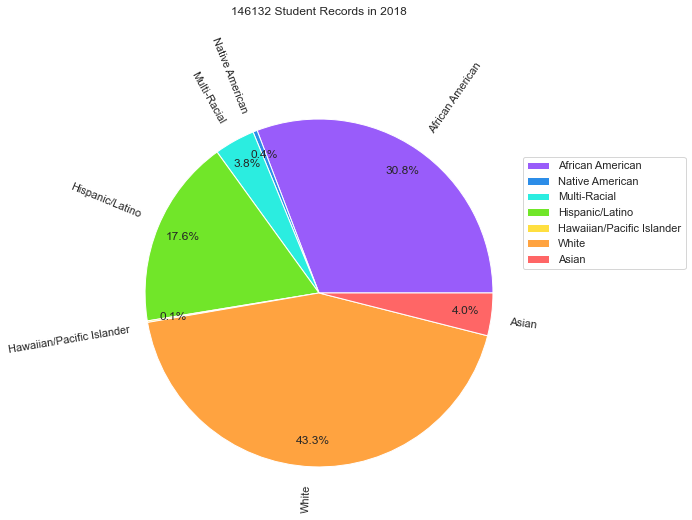

Total number of students: 146132

Number of Hawaiian/Pacific Islander students per year
 School Year  Students
        2015     164.0
        2016     183.0
        2017     208.0
        2018     205.0
        2019     187.0


In [45]:
# Setting up pie chart
pie_df = att_state_all[['SubGroup','Students','School Year']]
pie_df = pie_df.set_index('SubGroup')
pie_colors = ['#995cfa','#2c8de8','#2bede0',  '#71e629', '#ffdf40','#ffa340','#ff6666']

# Using most recent year without strange behaviors
year = 2018

att_pie_2019 = pie_df[pie_df['School Year'] == year].reindex(plotOrderReversed).plot.pie( 
    y='Students', 
    figsize=(5, 5),
    labels = plotOrderReversed,
    autopct='%1.1f%%',
    pctdistance=.85,
    radius = 1.6,
    rotatelabels = True,
    ylabel = '',
    colors = pie_colors
)

totalStudents = str(int(pie_df[pie_df['School Year'] == year]['Students'].sum() ) )

plt.title( totalStudents + " Student Records in " + str(year), y=1.5)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0)
plt.show()

print ( "Total number of students: " +  totalStudents)

print("\nNumber of Hawaiian/Pacific Islander students per year")
print(att_state_all.loc[ att_state_all["SubGroup"] == "Hawaiian/Pacific Islander", ['School Year','Students'] ].to_string(index=False)) 

Hawaiian/Pacific Islander students make up such a small portion of the data (.1%) that small changes will have more of an effect on the averages and percentages.

To put this into perspective:
* There are about 150 - 200 Hawaiian/Pacific Islander students each year
* A 4% increase in the percent of chronically absent students (like from 2016-2017) would only require about 6-8 additional students to be chronically absent. 

Because of how susceptible this small size of data is to small changes and outliers, we are not able to draw any substantial conclusions for this group.  


#### Effect Size

To get a better sense of the data, here we imagine the breakdown of students for a hypothetical sample of 10,000 students, based on the 2018 data. 

Out of 10,000 K-12 students:
* Hawaiian/Pacific Islander
    * 10 students would be Hawaiian/Pacific Islander
    * 2 Hawaiian/Pacific Islander students would be chronically absent (19.02%)
* Native American
    * 40 students would be Native American
    * 8 Native American students would be chronically absent (20.28%)
* Multi-Racial
    * 380 students would be Multi-Racial
    * 72 Multi-Racial students would be chronically absent (18.86%)
* Asian
    * 400 students would be Asian
    * 32 Asian American students would be chronically absent (8.42%)
* Hispanic/Latino
    * 1760 students would be Multi-Racial
    * 305 Multi-Racial students would be chronically absent (17.35%)
* African American
    * 3080 students would be African American
    * 637 African American students would be chronically absent (20.7%)
* White
    * 4330 students would be White
    * 620 white students would be chronically absent (14.32%)
    

With this, it is apparent how small the number of students are for Hawaiian/Pacific Islanders and Native Americans. We can also see a rather large disparity between African American and White students. Using this hypothetical sample, there are more African American students chronically absent, even though there are about 1,000 less African American students than White students. 

#### Conclusions

Across both graphs showing absence statistics across the years, the order of the groups were consistent across the years (ie: some groups consistently had high or lower rates of chronic absence). When looking at the 2018 data, these differences where statistically significant. Native Americans and African Americans, who've had a long history of being discriminated against in the U.S., have higher rates of chronic student absence and average number of days absent. 

These differences are echoed in national data, which indicates that inequalities are still present, not just in Delaware, but in the U.S. as well [6]. These inequalities may not lie wholly in education either. For example there could be general bias and inequality still present in society as a whole. This could lead to poorer circumstances in living and/or health conditions which could then result in more absences. There are also other factors to consider, like students' confidence in their own abilities, their experiences at school, and how that may impact missing school. 

Looking to research done in other states, Sacramento City Unified School District conducted a survey on chronically absent students and found that their students' main reasons for absence also varied by race, highlighting some of the racial differences in experience still relavent today. For example, they found that "while physical health was reported as a problem for 26% of chronically absent Asian students and 20% of chronically absent White students, it was reported as a problem for 42% of chronically absent Black students and 41% of chronically absent Latino students." They also noted that Black students were about 1.5x more likely to cite transportation as an issue than the overall population [7].

With the data analyzed here, we can only really point out a difference and speculate; we cannot come to any concrete conclusions about the main causes for chronic absence in Delaware. It would be worth it for the state of Delaware to look into the reasons more, in order to better address the issue of chronic absence and inequity in education in the future. 

## Student Dropout Analysis

Next, let's take a look at the student dropout dataset.

#### Data Overview

In [41]:
# Organizing the data
do_state = dropout[ dropout["District Code"] == 0]
do_state = do_state[(do_state['Grade'] == 'All Students') &
                      (do_state['Gender'] == 'All Students') &
                      (do_state['SpecialDemo'] == 'All Students') &
                      (do_state['SubGroup'] != 'All Students')]

print("\nHere is a preview of the data: ")
do_state.head()


Here is a preview of the data: 


,School Year,District Code,District,School Code,Organization,Race,Gender,Grade,SpecialDemo,Geography,SubGroup,RowStatus,Dropouts,Students,PctDropouts
4,2015,0,State of Delaware,0,State of Delaware,Hispanic/Latino,All Students,All Students,All Students,All Students,Hispanic/Latino,REPORTED,158.0,4986.0,3.2
70,2015,0,State of Delaware,0,State of Delaware,Native American,All Students,All Students,All Students,All Students,Native American,REPORTED,6.0,151.0,4.0
88,2015,0,State of Delaware,0,State of Delaware,African American,All Students,All Students,All Students,All Students,African American,REPORTED,358.0,12773.0,2.8
154,2015,0,State of Delaware,0,State of Delaware,White,All Students,All Students,All Students,All Students,White,REPORTED,326.0,19659.0,1.7
219,2015,0,State of Delaware,0,State of Delaware,Asian American,All Students,All Students,All Students,All Students,Asian,REDACTED,NaN,1379.0,NaN


#### Demographics
The distribution of students across the subgroups for this dataset appear relatively the same as before.

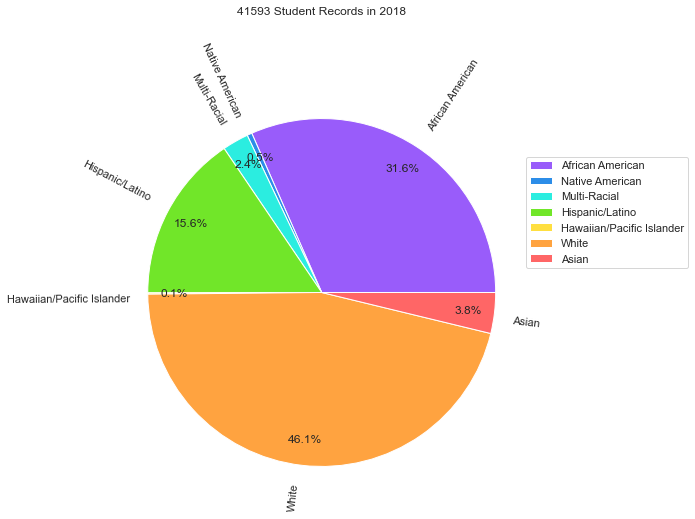

Total number of students: 41593


In [44]:
pie_df = do_state[['SubGroup','Students','School Year']]
pie_df = do_state.set_index('SubGroup')

do_pie_2018 = pie_df[pie_df['School Year'] == 2018].reindex(plotOrderReversed).plot.pie( 
    y='Students', 
    figsize=(5, 5),
    labels = plotOrderReversed,
    autopct='%1.1f%%',
    pctdistance=.85,
    radius = 1.6,
    rotatelabels = True,
    ylabel = '',
    colors = pie_colors
)

totalStudents = str(int(pie_df[pie_df['School Year'] == 2018]['Students'].sum() ) )
plt.title( totalStudents + " Student Records in 2018", y=1.5)
plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0)
plt.show()

print ( "Total number of students: " +  totalStudents)

In addition to the small number of students for Hawaiian/Pacific Islanders again, much of the dropout information for Hawaiian/Pacific Islanders, Native Americans, and Asians were redacted from being reported:

In [47]:
do_state[do_state['RowStatus'] == 'REDACTED'].head()

,School Year,District Code,District,School Code,Organization,Race,Gender,Grade,SpecialDemo,Geography,SubGroup,RowStatus,Dropouts,Students,PctDropouts
219,2015,0,State of Delaware,0,State of Delaware,Asian American,All Students,All Students,All Students,All Students,Asian,REDACTED,NaN,1379.0,NaN
242,2015,0,State of Delaware,0,State of Delaware,Hawaiian/Pacific Islander,All Students,All Students,All Students,All Students,Hawaiian/Pacific Islander,REDACTED,NaN,40.0,NaN
6576,2016,0,State of Delaware,0,State of Delaware,Native American,All Students,All Students,All Students,All Students,Native American,REDACTED,NaN,153.0,NaN
6723,2016,0,State of Delaware,0,State of Delaware,Asian American,All Students,All Students,All Students,All Students,Asian,REDACTED,NaN,1435.0,NaN
6735,2016,0,State of Delaware,0,State of Delaware,Hawaiian/Pacific Islander,All Students,All Students,All Students,All Students,Hawaiian/Pacific Islander,REDACTED,NaN,45.0,NaN



The Delaware Department of Education notes that redacted entries are to comply with privacy laws. It is likely that there are either too few students in these subgroups or too few students dropping out among these subgroups, such that students would be easily identifiable if the information was published. Because this information was not released, we will not be looking at these three subgroups in this dropout analysis section.

#### Percent of Students Dropping Out

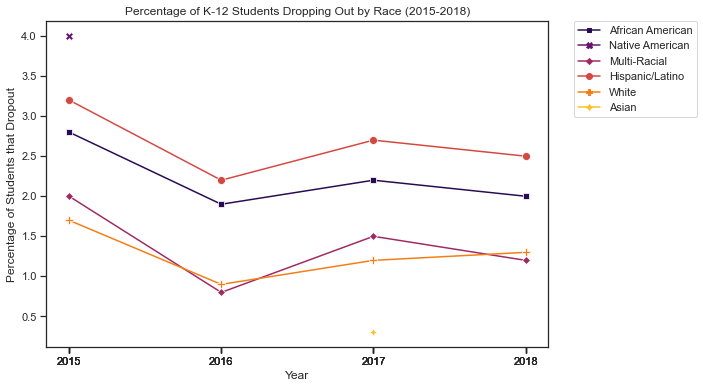

In [50]:
# get rid of all rows without dropout rate reports
do_state =  do_state[do_state['RowStatus'] != 'REDACTED']

# same order, sans hawaiian / pacific islander because redacted (no dropout numbers reported)
doOrder = ['Asian', 'White', 'Hispanic/Latino','Multi-Racial', 'Native American','African American']
doOrderReversed = doOrder[::-1]

do_plot = sns.lineplot(x = 'School Year',
                        y = 'PctDropouts',
                        data = do_state,
                        hue = 'SubGroup',
                        style = 'SubGroup',
                        markers = True,
                        dashes = False,
                        markersize = 8,
                        hue_order = doOrderReversed,
                        palette = 'inferno'
                      )


do_plot.set_xticks(do_state['School Year'].values)
do_plot.set(xlabel='Year', ylabel="Percentage of Students that Dropout", title="Percentage of K-12 Students Dropping Out by Race (2015-2018)")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

aaaaaaaaaaa stuuf here

Citations 

1. “K-12 Disparity Facts and Statistics.” UNCF, United Negro College Fund, 20 Mar. 2020, https://uncf.org/pages/k-12-disparity-facts-and-stats.
2. Dhaliwal, Tasminda K, et al. “Educator Bias Is Associated with Racial Disparities in Student Achievement and Discipline.” Brookings, The Brookings Institute, 20 July 2020, www.brookings.edu/blog/brown-center-chalkboard/2020/07/20/educator-bias-is-associated-with-racial-disparities-in-student-achievement-and-discipline/.
3. Davis, Theodore J. “The Politics of Race and Educational Disparities in Delaware’s Public Schools.” Education and Urban Society, vol. 49, no. 2, 2016, pp. 135–162., doi:10.1177/0013124516633503, https://journals-sagepub-com.udel.idm.oclc.org/doi/pdf/10.1177/0013124516633503.
4. Skye Davis, Elizabeth, et al. “Racial Disparities in Delaware’s Public Schools Require Attention and Action.” DiversityUS, University of Delaware, 9 May 2014, https://sites.udel.edu/csd/2014/05/09/racial-disparities-in-delawares-public-schools/.
5. Rivera-Batiz, Francisco L. Columbia University, 2008, Educational Inequality and the Latino Population of the United States, https://files.eric.ed.gov/fulltext/ED524001.pdf.
6. https://www2.ed.gov/datastory/chronicabsenteeism.html
7. https://regionalchange.ucdavis.edu/sites/g/files/dgvnsk986/files/inline-files/N%20Erbstein%20Brief_Factors-Influencing-School-Attendance.pdf